<a href="https://colab.research.google.com/github/rahmaashraf310/Heart_Disease_Project/blob/main/notebooks/03_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/rahmaashraf310/Heart_Disease_Project.git
%cd Heart_Disease_Project


Cloning into 'Heart_Disease_Project'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 221.20 KiB | 2.17 MiB/s, done.
/content/Heart_Disease_Project


In [4]:
!mkdir -p data notebooks models results


In [5]:
!ls


data  models  notebooks  README.md  results


Extracted files: ['.config', 'long-beach-va.data', 'costs', 'processed.va.data', 'Index', 'heart+disease.zip', 'Heart_Disease_Project', 'bak', 'reprocessed.hungarian.data', 'cleveland.data', 'processed.cleveland.data', 'WARNING', 'new.data', 'processed.switzerland.data', 'switzerland.data', 'heart-disease.names', 'hungarian.data', 'ask-detrano', 'cleve.mod', 'processed.hungarian.data', 'sample_data']
Shape: (303, 14)
Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


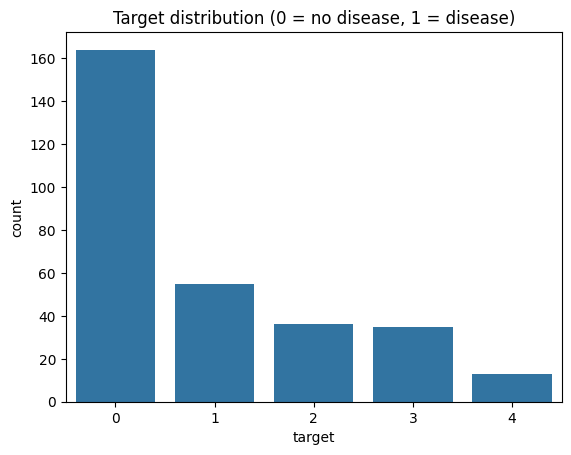

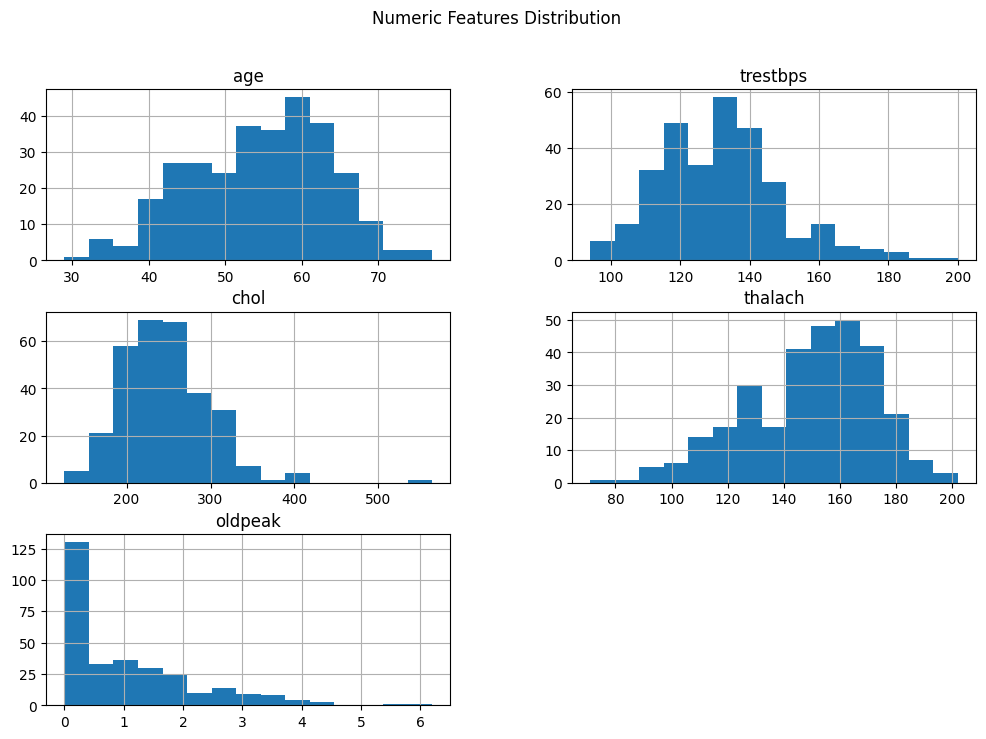

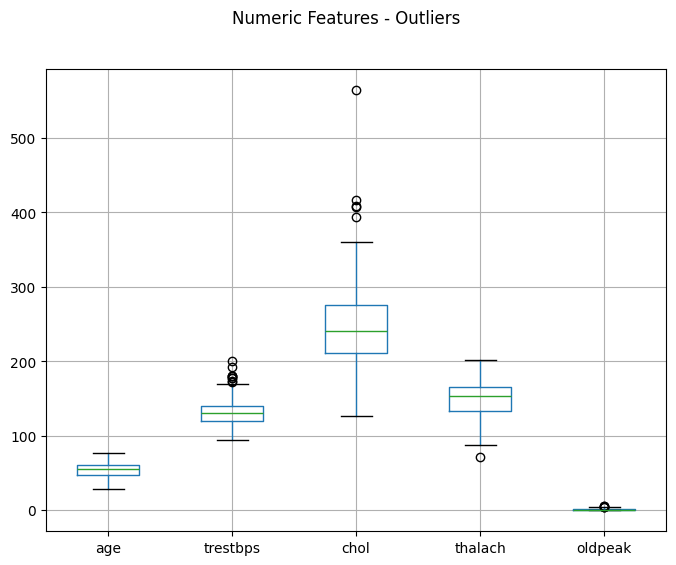

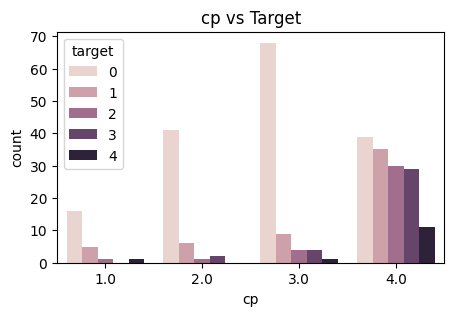

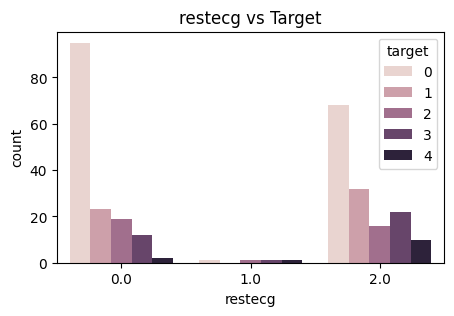

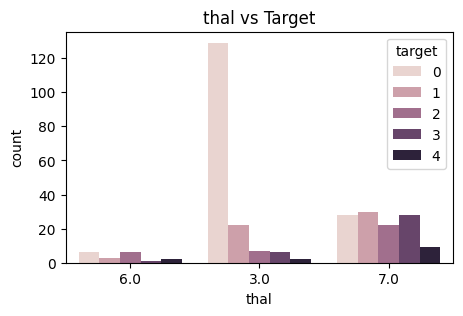

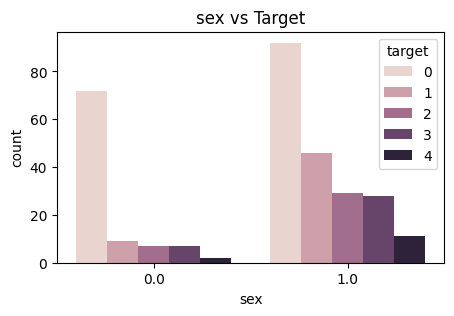

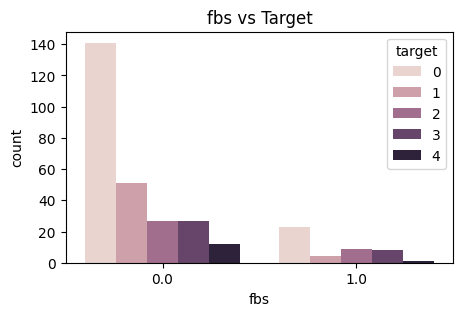

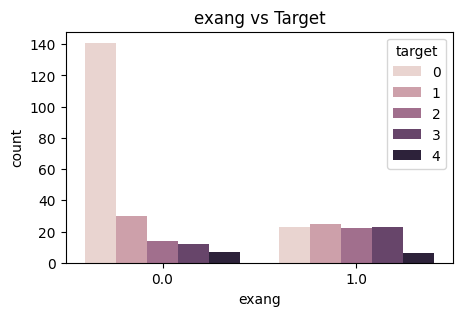

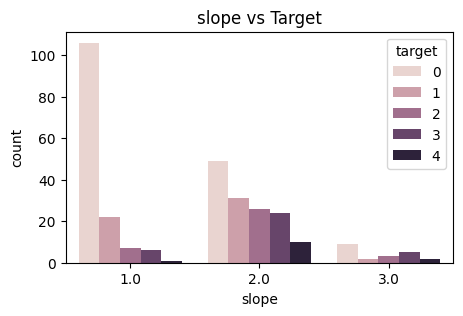

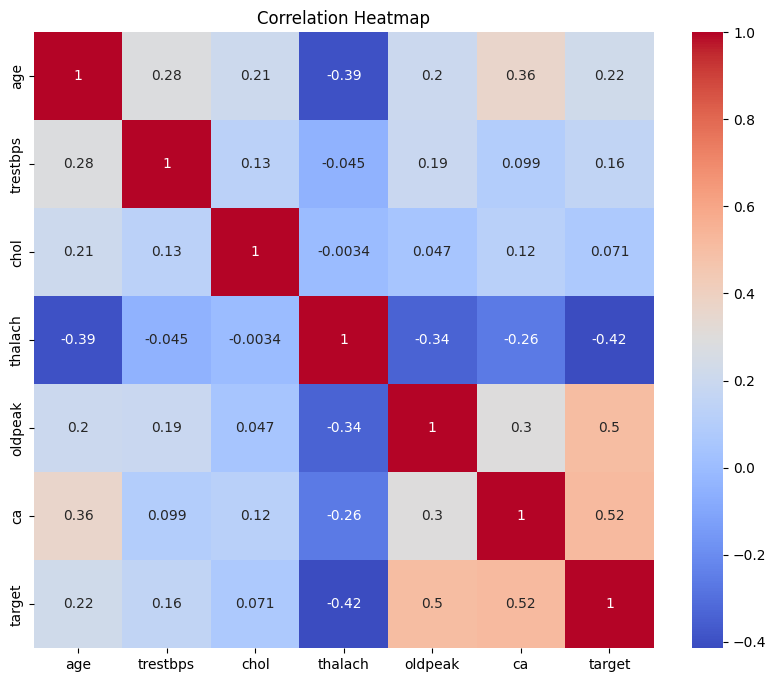

age         float64
trestbps    float64
chol        float64
thalach     float64
oldpeak     float64
ca          float64
dtype: object
Missing after conversion:
 age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
ca          4
dtype: int64


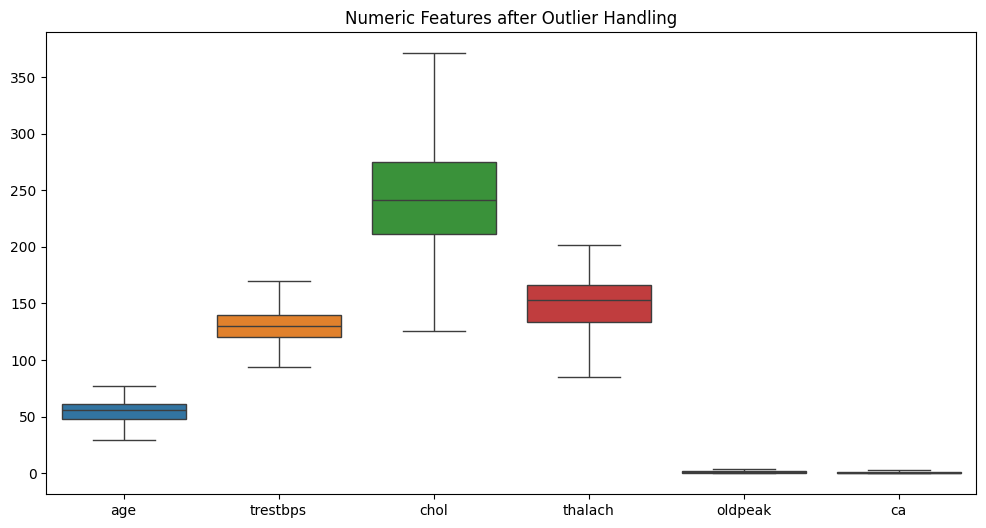

✅ Cleaned dataset saved to data/heart_clean.csv


In [7]:
# =============================
# Heart Disease Project — Step 1
# Data Loading, Cleaning & EDA
# =============================

# 1. Unzip data (if zip file is present in /content)
import zipfile
import os

# path to your zip file
zip_path = "/content/heart+disease.zip"   # update with your actual path
extract_to = "/content/"

# unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# list extracted files
print("Extracted files:", os.listdir(extract_to))

# 2. Load dataset
import pandas as pd

file_path = "/content/processed.cleveland.data"

columns = [
    "age", "sex", "cp", "trestbps", "chol",
    "fbs", "restecg", "thalach", "exang",
    "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv(file_path, header=None, names=columns)
print("Shape:", df.shape)
df.head()

# 3. Replace missing values ("?")
import numpy as np
df = df.replace("?", np.nan)

print("Missing values:\n", df.isna().sum())

# 4. Target distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=df)
plt.title("Target distribution (0 = no disease, 1 = disease)")
plt.show()

# 5. Numeric distributions
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]

df[numeric_features].hist(bins=15, figsize=(12,8))
plt.suptitle("Numeric Features Distribution")
plt.show()

# 6. Boxplots (outliers)
df[numeric_features].boxplot(figsize=(8,6))
plt.suptitle("Numeric Features - Outliers")
plt.show()

# 7. Categorical feature counts
binary_features = ["sex", "fbs", "exang"]
nominal_features = ["cp", "restecg", "thal"]
ordinal_features = ["slope"]

for col in nominal_features + binary_features + ordinal_features:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=df, hue="target")
    plt.title(f"{col} vs Target")
    plt.show()

# 8. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features + ["target"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 9. Convert numeric cols to numbers
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df[numeric_features].dtypes)
print("Missing after conversion:\n", df[numeric_features].isna().sum())

# 10. Handle outliers (IQR capping)
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(series, lower, upper)

for col in numeric_features:
    if col != "age":
        df[col] = cap_outliers_iqr(df[col])

# Check again
plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_features])
plt.title("Numeric Features after Outlier Handling")
plt.show()

# 11. Preprocessing pipelines (setup, not applied yet)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

slope_order = [[1, 2, 3]]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

binary_transformer = "passthrough"

nominal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=slope_order))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("bin", binary_transformer, binary_features),
    ("nom", nominal_transformer, nominal_features),
    ("ord", ordinal_transformer, ordinal_features)
])

# 12. Save cleaned dataset
os.makedirs("data", exist_ok=True)
df.to_csv("data/heart_clean.csv", index=False)
print("✅ Cleaned dataset saved to data/heart_clean.csv")


Shape: (303, 14)
Processed feature matrix shape: (303, 20)


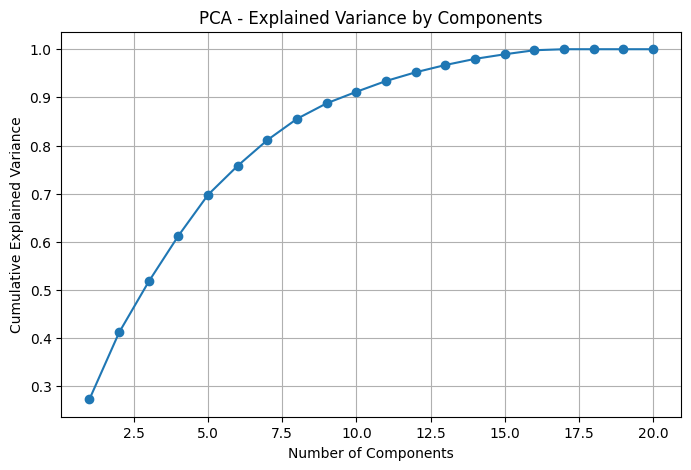

Original shape: (303, 20)
Reduced shape: (303, 10)


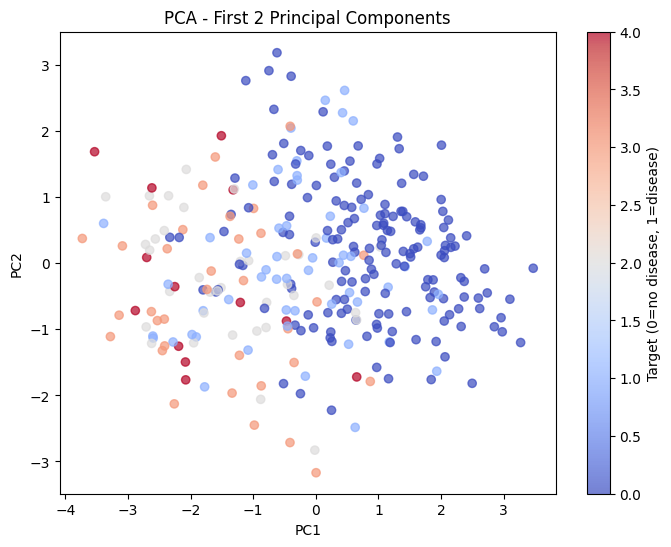

✅ PCA-transformed dataset saved to results/pca_transformed.csv


In [8]:
# =============================================
# Heart Disease Project — Step 2.2 PCA Analysis
# =============================================

# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load preprocessor from Step 1
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# 2. Load cleaned dataset
df = pd.read_csv("data/heart_clean.csv")
print("Shape:", df.shape)
df.head()

# 3. Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# 4. Define columns (same as before)
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
binary_features = ["sex", "fbs", "exang"]
nominal_features = ["cp", "restecg", "thal"]
ordinal_features = ["slope"]

slope_order = [[1, 2, 3]]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
binary_transformer = "passthrough"
nominal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=slope_order))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("bin", binary_transformer, binary_features),
    ("nom", nominal_transformer, nominal_features),
    ("ord", ordinal_transformer, ordinal_features)
])

# 5. Transform dataset
X_processed = preprocessor.fit_transform(X)
print("Processed feature matrix shape:", X_processed.shape)

# 6. Apply PCA
pca = PCA().fit(X_processed)

# 7. Explained variance plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance by Components")
plt.grid(True)
plt.show()

# 8. Choose components to retain ~90% variance
pca_90 = PCA(n_components=0.90)
X_pca = pca_90.fit_transform(X_processed)
print("Original shape:", X_processed.shape)
print("Reduced shape:", X_pca.shape)

# 9. 2D scatter plot of first 2 PCs
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - First 2 Principal Components")
plt.colorbar(label="Target (0=no disease, 1=disease)")
plt.show()

# 10. Save PCA-transformed dataset
import numpy as np
pca_df = pd.DataFrame(X_pca)
pca_df["target"] = y.reset_index(drop=True)
pca_df.to_csv("results/pca_transformed.csv", index=False)
print("✅ PCA-transformed dataset saved to results/pca_transformed.csv")


Dataset shape: (303, 13)


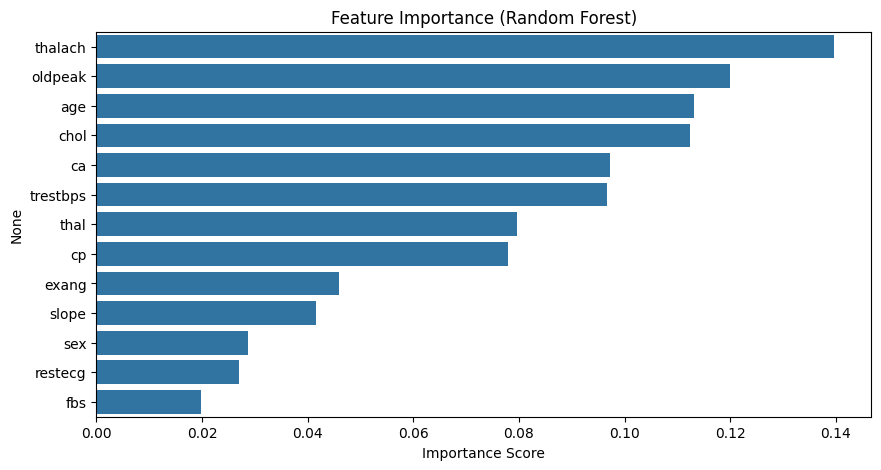

Top features by Random Forest:
 thalach     0.139706
oldpeak     0.120006
age         0.113118
chol        0.112458
ca          0.097234
trestbps    0.096649
thal        0.079614
cp          0.078012
exang       0.045911
slope       0.041650
dtype: float64
Top features by RFE: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca']
Chi-square feature scores:
 ca         99.976551
thal       70.294698
exang      41.534482
cp         16.881183
restecg    14.057550
slope      10.542204
sex         7.499223
fbs         6.658223
dtype: float64
Final selected features: ['oldpeak', 'exang', 'ca', 'chol', 'cp', 'fbs', 'thal', 'sex', 'age', 'slope', 'thalach', 'restecg', 'trestbps']
✅ Reduced dataset saved to results/selected_features.csv
✅ Reduced dataset saved to results/selected_features.csv


In [16]:
# =============================================
# Heart Disease Project — Step 2.3 Feature Selection
# =============================================

# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# ---------------------------------------------
# 2. Load cleaned dataset
# ---------------------------------------------
df = pd.read_csv("data/heart_clean.csv")

# Features and target
X = df.drop("target", axis=1)
y = df["target"]

print("Dataset shape:", X.shape)

# Define feature groups
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
nominal_features = ["cp", "restecg", "thal"]
ordinal_features = ["slope"]

# Handle missing values
num_imputer = SimpleImputer(strategy="median")
X[numeric_features] = num_imputer.fit_transform(X[numeric_features])

cat_imputer = SimpleImputer(strategy="most_frequent")
for col in nominal_features + ordinal_features:
    if col in X.columns:
        X[[col]] = cat_imputer.fit_transform(X[[col]])

# ---------------------------------------------
# 3. Feature Importance (Random Forest)
# ---------------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

print("Top features by Random Forest:\n", feat_imp.head(10))

# ---------------------------------------------
# 4. Recursive Feature Elimination (RFE)
# ---------------------------------------------
model = LogisticRegression(max_iter=1000, solver="liblinear")
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_]
print("Top features by RFE:", list(rfe_features))

# ---------------------------------------------
# 5. Chi-Square Test (categorical features only)
# ---------------------------------------------
cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

X_chi = X[cat_features].copy()
chi_imputer = SimpleImputer(strategy="most_frequent")
X_chi = pd.DataFrame(chi_imputer.fit_transform(X_chi), columns=cat_features)

chi_selector = SelectKBest(score_func=chi2, k="all")
chi_selector.fit(X_chi, y)

chi_scores = pd.Series(chi_selector.scores_, index=cat_features).sort_values(ascending=False)
print("Chi-square feature scores:\n", chi_scores)

# ---------------------------------------------
# 6. Define final selected features
# (Union of RF top 8 and RFE features)
# ---------------------------------------------
final_features = list(set(feat_imp.head(8).index) | set(rfe_features))
print("Final selected features:", final_features)

X_reduced = X[final_features]
reduced_df = pd.concat([X_reduced, y], axis=1)

# ---------------------------------------------
# 7. Save reduced dataset
# ---------------------------------------------
reduced_df.to_csv("results/selected_features.csv", index=False)
print("✅ Reduced dataset saved to results/selected_features.csv")